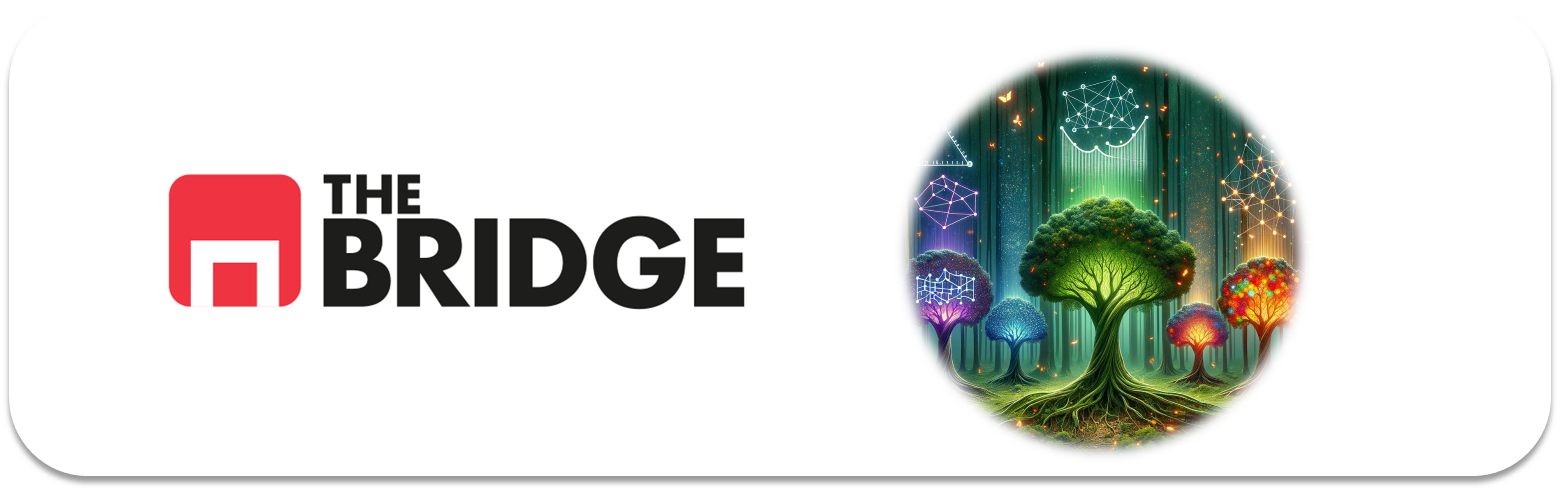

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [591]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from scipy.stats import mannwhitneyu 

from bootcampviztools import plot_categorical_relationship_fin, pinta_distribucion_categoricas, plot_categorical_numerical_relationship, plot_combined_graphs, \
    plot_grouped_boxplots, plot_grouped_histograms, grafico_dispersion_con_correlacion, bubble_plot

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

----

## Proceso de creación de un modelo de ML

### 1. Entender el problema de negocio y trasladarlo al problema técnico

PROBLEMA DE NEGOCIO: Predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo (target 'y')

PROBLEMA TÉCNICO: Modelo de aprendizaje supervisado -> Árboles de decisión --> aplicación a la clasificación

### 2. Obtención de los datos

In [592]:
df_bank = pd.read_csv("./data/bank-full.csv", sep = ";")

df_bank 

# A simple vista, observamos que hay variables con valores 'unknown'. En la posterior visualización veremos su distribución para ver si son relevantes, a priori parece que sí.
# La variable 'poutcome' en particular parece que no es demasiado relevante, ya que contiene muchos unkownn y other, investigaremos más a fondo.
# Vamos a estudiar las variables 'age' y 'pdays', ya que tal vez nos interesa más emplearlas como categóricas
# Convertiremos las variables binarias en 0 y 1 
# Convertiremos las categóricas no binarias en ordinales (ej: month, marital) 
# Veremos si hay alguna variable redundante (job / education)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


### 3. Visualización y limpieza de datos

In [593]:
df_bank.info()  # no hay valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [594]:
# ya tenemos definida nuestra target en la variable 'y', si el cliente se suscribirá o no a un depósito a plazo. 
# es decir, es binaria, por lo que estamos ante un modelo de árboles de decision aplicados a la clasificación.

target = df_bank.y

# Veamos su distribución, la inmensa mayoría NO. Es una variable con bastante descompensación en los datos.
target.value_counts(normalize=True) 

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

<Axes: >

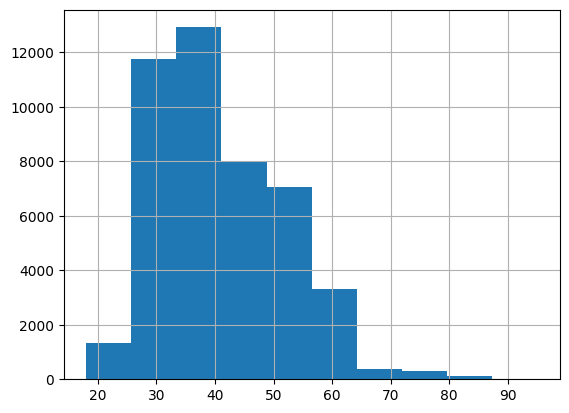

In [595]:
# TRATAMIENTO DE OTRAS VARIABLES

# vamos a convertir nuestra variable numérica 'age' a 'categórica' sesgando por intervalos de edad
# veamos la distribución del histograma 


df_bank.age.hist()

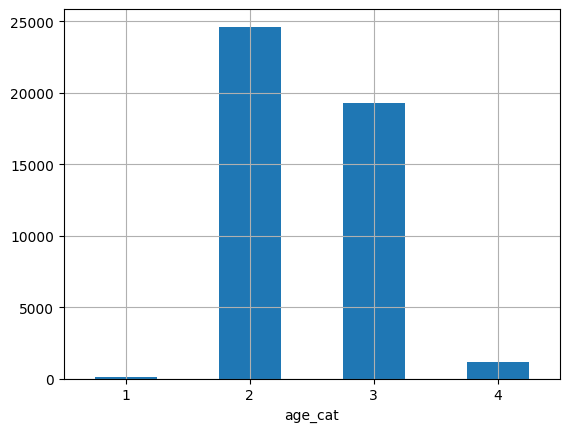

In [596]:
df_bank["age_cat"] = pd.cut(df_bank["age"],
                               bins=[0., 20, 40, 60, np.inf], # definimos los intervalos donde pondremos el límite de los valores que caen en cada categoria
                               labels=[1, 2, 3, 4])  # y asignamos una etiqueta a cada categoria anterior

df_bank["age_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True); 

In [597]:
# de las 45 mil entradas que hay en el data set, 36 mil tienen el valor -1 en pdays, es decir, los clientes con este valor no han sido contactados en campañas anteriores

df_bank.pdays.value_counts() 

pdays
-1      36954
 182      167
 92       147
 183      126
 91       126
        ...  
 749        1
 769        1
 587        1
 778        1
 854        1
Name: count, Length: 559, dtype: int64

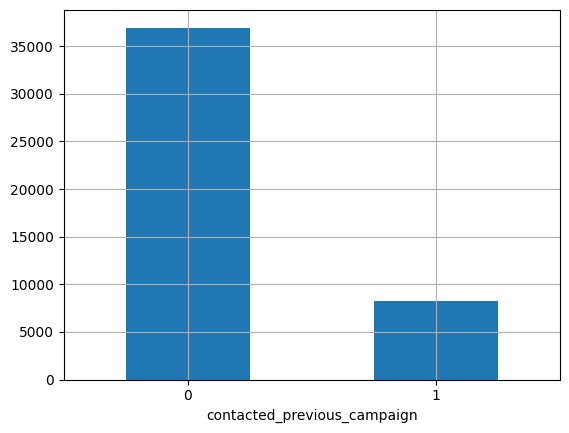

In [598]:
# dividimos esta variable en binaria: 0 SÍ han sido contactado en campañas previas /1  NO han sido contactados en campañas previas

df_bank["contacted_previous_campaign"] = pd.cut(df_bank["pdays"],
                               bins=[-np.inf, -1, np.inf], # definimos los intervalos donde pondremos el límite de los valores que caen en cada categoria
                               labels=[0, 1])  # y asignamos una etiqueta a cada categoria anterior

df_bank["contacted_previous_campaign"].value_counts().sort_index().plot.bar(rot=0, grid=True); 


In [599]:
df_bank.poutcome.value_counts() # esta variable no aporta datos en una vasta mayoría de las instancias pero contiene el resultado de la campaña previa de marketing
                                # de momento la guardamos por si los datos que sí tenemos resultan relevantes. Ya veremos si la utilizamos como feature o no

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [600]:
df_bank.job.value_counts()

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

In [601]:
df_bank.education.value_counts()   # job y education pueden parecer variables similares, veremos cuál está más relacionada con nuestra target en el mini-EDA

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

In [602]:
# Convertiremos las variables binarias en 0 y 1

ordinal_encoder = OrdinalEncoder()

In [603]:
df_backup = df_bank.copy() # hacemos una copia de seguridad antes de modificar las variables

In [604]:
df_bank["default_binary"] = ordinal_encoder.fit_transform(df_bank[["default"]])

df_bank[["default","default_binary"]].sample(10)  # comprobamos que está bien hecho

,default,default_binary
28422,no,0.0
9116,no,0.0
39150,no,0.0
40833,no,0.0
30423,no,0.0
9239,no,0.0
35146,no,0.0
1769,no,0.0
21739,no,0.0
9001,no,0.0


In [605]:
# lo mismo con el resto, primero las binarias

df_bank["housing_binary"] = ordinal_encoder.fit_transform(df_bank[["housing"]])


df_bank["loan_binary"] = ordinal_encoder.fit_transform(df_bank[["loan"]])

In [606]:
# y las categóricas no binarias


df_bank["job_num"] = ordinal_encoder.fit_transform(df_bank[["job"]])


df_bank["marital_num"] = ordinal_encoder.fit_transform(df_bank[["marital"]])


df_bank["contact_num"] = ordinal_encoder.fit_transform(df_bank[["contact"]])

# para las que nos quedan, nosotros establecemos el orden que nos interesa 

categories_education = [["unknown","primary","secondary","tertiary"]] # siendo unknown 0 seguida de cada sector con su correspondiente numeración
ordinal_encoder = OrdinalEncoder(categories= categories_education)
df_bank["education_ordinal"] = ordinal_encoder.fit_transform(df_bank[["education"]])


categories_month = [["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]] # ordenados según el calendario
ordinal_encoder = OrdinalEncoder(categories= categories_month) 
df_bank["month_ordinal"] = ordinal_encoder.fit_transform(df_bank[["month"]])

categories_outcome = [["failure", "success", "other", "unknown"]]  # siendo 0 failure, 1 success seguidas del resto
ordinal_encoder = OrdinalEncoder(categories= categories_outcome)
df_bank["poutcome_ordinal"] = ordinal_encoder.fit_transform(df_bank[["poutcome"]])


In [607]:
 # comprobamos un par de ellas para ver que está bien hechodf_bank[["education","education_ordinal"]].sample(10) 

In [608]:
df_bank[["month","month_ordinal"]].sample(10) 

,month,month_ordinal
37871,may,4.0
3074,may,4.0
36524,may,4.0
33359,apr,3.0
3498,may,4.0
29980,feb,1.0
16279,jul,6.0
40610,aug,7.0
22329,aug,7.0
18688,jul,6.0


In [609]:
# previous y campaing aportan la misma info (campaing un poco más), así que desechamos previous
df_bank.drop(columns="previous", inplace=True)

In [610]:
# nos deshacemos de las variables originales que hemos convertido para simplificar el dataset, tenemos una copia en df_backup por si necesitamos alguna referencia

df_bank.drop(columns=["age","pdays","default", "housing", "loan","job", "marital", "contact","education","month","poutcome"], inplace=True)

### 4. Train /  test split

In [611]:
X = df_bank.drop('y', axis=1)   # quitamos el target del conjunto de datos antes de entrenar

X_train, X_test, y_train, y_test = train_test_split(X, target,
                                                    test_size=0.2,
                                                    random_state=42)

### 5. Mini-EDA

In [612]:
# Sobre el Train ya estudio el target, la bivarianza del target con las posibles features (Mini-EDA) --> obtengo una lista de potenciales features

df_eda = X_train.copy()
df_eda["y"] = y_train.copy() # añadimos el target a la partición de train para poder estudiarla junto con el resto de variables

In [613]:
df_eda

,balance,day,duration,campaign,age_cat,contacted_previous_campaign,default_binary,housing_binary,loan_binary,job_num,marital_num,contact_num,education_ordinal,month_ordinal,poutcome_ordinal,y
3344,849,15,72,1,3,0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,4.0,3.0,no
17965,1415,30,269,2,3,0,0.0,1.0,0.0,9.0,1.0,0.0,1.0,6.0,3.0,no
18299,3842,31,130,4,3,0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,6.0,3.0,no
10221,-119,11,375,11,2,0,0.0,1.0,0.0,4.0,2.0,2.0,3.0,5.0,3.0,no
32192,3498,15,264,2,3,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0,3.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1059,18,2093,1,3,0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,5.0,3.0,yes
44732,508,8,210,1,2,1,0.0,0.0,0.0,8.0,2.0,0.0,3.0,8.0,0.0,no
38158,1317,15,239,1,2,0,0.0,1.0,0.0,9.0,0.0,0.0,3.0,4.0,3.0,no
860,165,7,111,1,2,0,0.0,0.0,0.0,5.0,1.0,2.0,2.0,4.0,3.0,no


In [614]:
def tipifica_variables(dataframe, umbral_categoria = int, umbral_continua = float):

    df_resultado = pd.DataFrame([dataframe.nunique(), dataframe.nunique()/len(dataframe)*100]).T.rename(columns = {0: "Cardinalidad", 1: "%_Cardinalidad"})
    
    df_resultado["Tipo"] = "Numérica Discreta"
    df_resultado.loc[df_resultado["Cardinalidad"] < umbral_categoria, "Tipo"] = "Categórica"
    df_resultado.loc[df_resultado["Cardinalidad"] == 2.0, "Tipo"] = "Binaria"
    df_resultado.loc[df_resultado["%_Cardinalidad"] >= umbral_continua, "Tipo"] = "Numérica Continua"

    return df_resultado

In [615]:
# llamo a mi función automatizar la clasificación de las variables del dataset 

df_tipificado = tipifica_variables(df_eda, umbral_categoria= 13, umbral_continua= 18.00) # umbral cat 13 por la varible month
df_tipificado

,Cardinalidad,%_Cardinalidad,Tipo
balance,6652.0,18.391949,Numérica Continua
day,31.0,0.085711,Numérica Discreta
duration,1493.0,4.127958,Numérica Discreta
campaign,47.0,0.129949,Numérica Discreta
age_cat,4.0,0.011060,Categórica
contacted_previous_campaign,2.0,0.005530,Binaria
default_binary,2.0,0.005530,Binaria
housing_binary,2.0,0.005530,Binaria
loan_binary,2.0,0.005530,Binaria
job_num,12.0,0.033179,Categórica


In [616]:
es_binaria = df_tipificado.Tipo == "Binaria"    # creamos unas máscaras booleanas para filtrar las categóricas
es_catego = df_tipificado.Tipo == "Categórica"

lista_categoricas = df_tipificado.loc[es_binaria | es_catego].index.to_list()  # las pasamos a una lista
lista_categoricas.remove("y")
lista_categoricas # ya tenemos la lista de todas las categóricas volcadas en una instancia 

['age_cat',
 'contacted_previous_campaign',
 'default_binary',
 'housing_binary',
 'loan_binary',
 'job_num',
 'marital_num',
 'contact_num',
 'education_ordinal',
 'month_ordinal',
 'poutcome_ordinal']

In [617]:
# repetimos el proceso con las variables numéricas

es_num = (df_tipificado.Tipo == "Numérica Discreta") | (df_tipificado.Tipo == "Numérica Continua")
lista_numericas = df_tipificado.loc[es_num].index.to_list()
lista_numericas 

['balance', 'day', 'duration', 'campaign']

In [618]:
# PARA LAS CATEGÓRICAS

# aplicamos el test chi-cuadrado contra la variable target para ver si supera el 95% de confianza estadística y así incluirlas como features
features_catego = []

for catego in lista_categoricas:

    tabla_contingencia = pd.crosstab(df_eda['y'], df_eda[catego])

    from scipy.stats import chi2_contingency

    chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
    
    if p <= 0.05:     # si el pvalue es igual o menor que 0.05, se añade el nombre de la variable a la lista de features
        features_catego.append(catego)    
        print(f"P-Value de {catego} con el target:", p) # imprimimos el pvalue de cada una para evaluarlo
print("\n")
print("Selección de features categóricas:") 
features_catego# todas tienen un p-value menor al 0.05 por lo que superan el test de confianza del 95%; observamos que el resultado de month y poutcome es 0

# la que más discrimina es contactes_previous_campaing, seguida de age

P-Value de age_cat con el target: 1.3791185006985252e-220
P-Value de contacted_previous_campaign con el target: 1.2943992268486161e-228
P-Value de default_binary con el target: 7.080028719182829e-06
P-Value de housing_binary con el target: 1.6499823834156134e-156
P-Value de loan_binary con el target: 9.345195944938004e-37
P-Value de job_num con el target: 4.020993953561374e-127
P-Value de marital_num con el target: 1.7805341122081173e-33
P-Value de contact_num con el target: 2.915476152357982e-186
P-Value de education_ordinal con el target: 4.8167076424285695e-39
P-Value de month_ordinal con el target: 0.0
P-Value de poutcome_ordinal con el target: 0.0


Selección de features categóricas:


['age_cat',
 'contacted_previous_campaign',
 'default_binary',
 'housing_binary',
 'loan_binary',
 'job_num',
 'marital_num',
 'contact_num',
 'education_ordinal',
 'month_ordinal',
 'poutcome_ordinal']

In [619]:
# plot_categorical_relationship_fin(df_eda, "month_ordinal", "y")

# Al ejecutar el código anterior, vemos que la distribución es siempre NO sobre SÍ exceptuando un par de meses. Los valores absolutos siempre son sospechoso, por lo que vamos
# a descartar esta variable. 


features_catego.remove("month_ordinal")

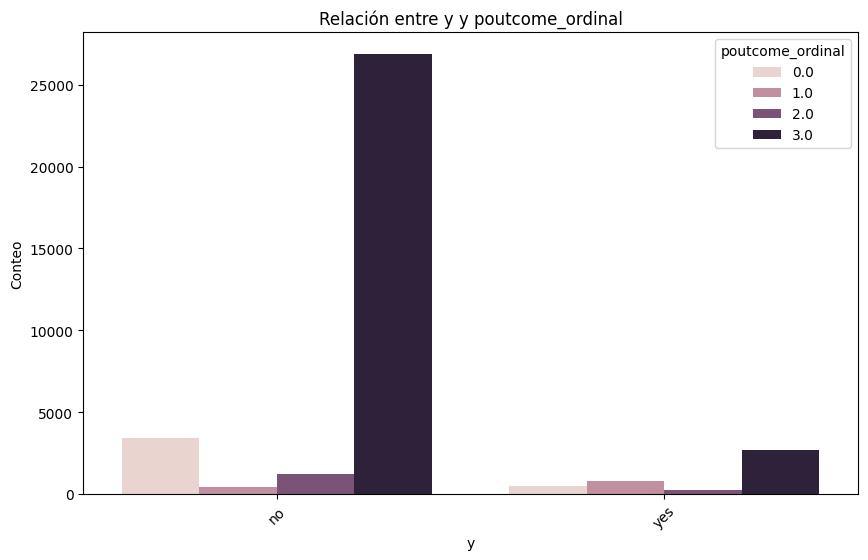

In [620]:
# Con poutcome ocurre lo mismo, la mayor parte de clientes caen en la categoria 3 unknkown; sin embargo, los pocos de los que sí tenemos info puede que nos aporten datos 
# muy relevantes, por lo que la vamos a mantener.

plot_categorical_relationship_fin(df_eda, "y","poutcome_ordinal")

c:\Users\tania\Desktop\Tania\Bootcamp\repo_local_ESPEJO\DS_Online_Febr25_Exercises\04_Machine_Learning\Sprint_11\Unidad_01\Practica_Obligatoria\bootcampviztools.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')


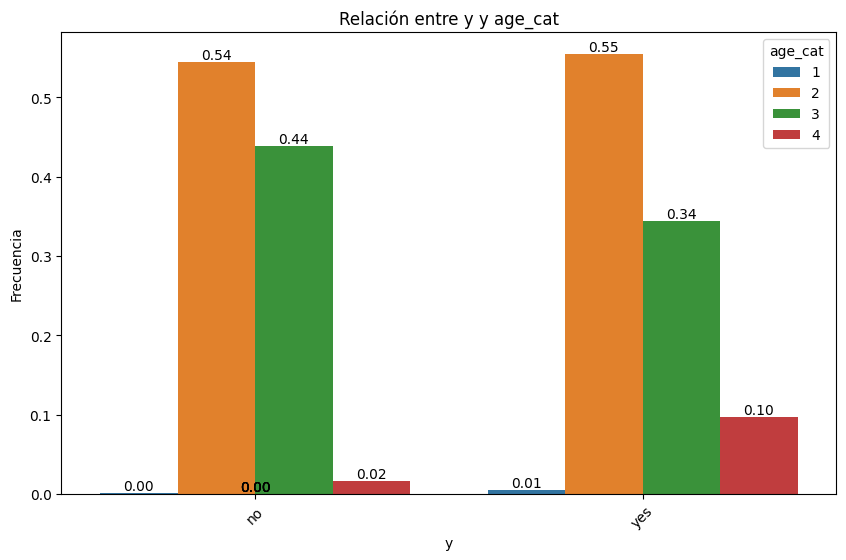

c:\Users\tania\Desktop\Tania\Bootcamp\repo_local_ESPEJO\DS_Online_Febr25_Exercises\04_Machine_Learning\Sprint_11\Unidad_01\Practica_Obligatoria\bootcampviztools.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')


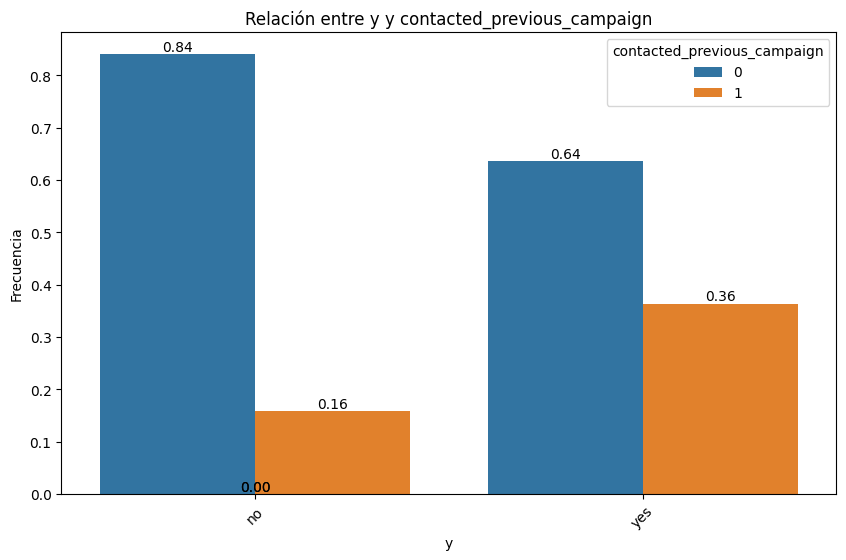

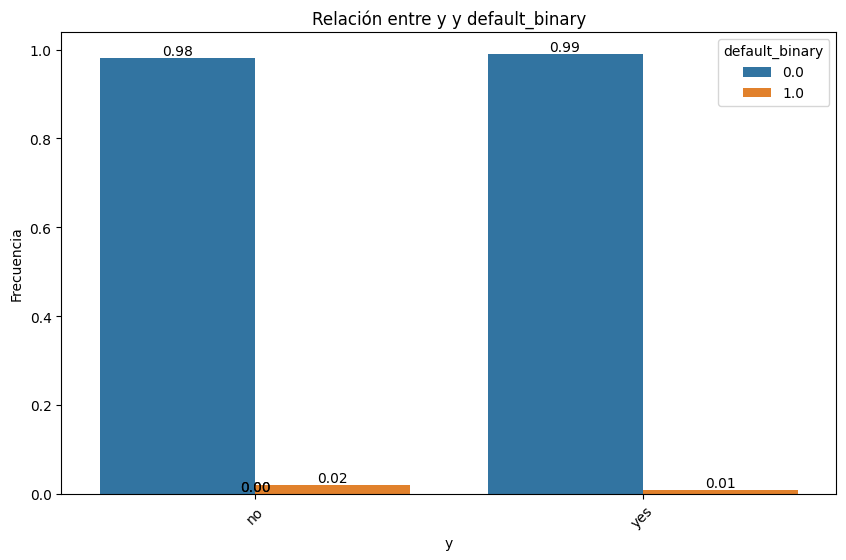

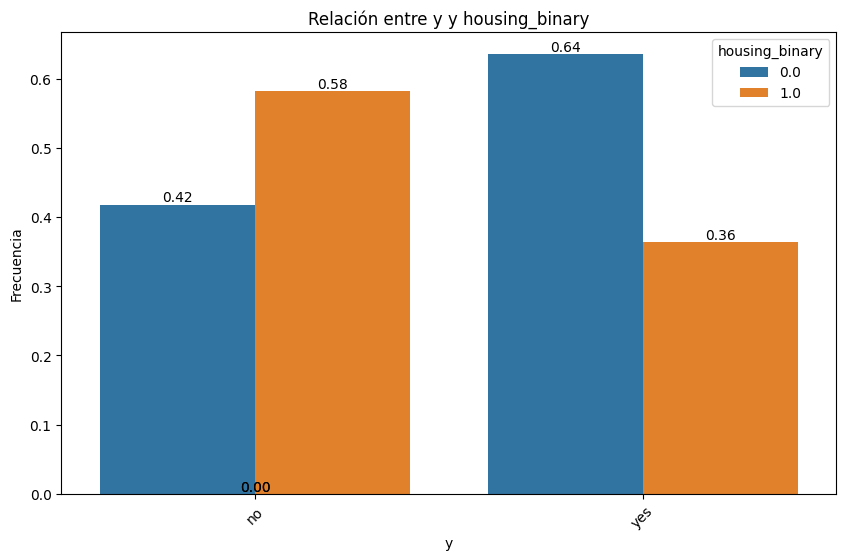

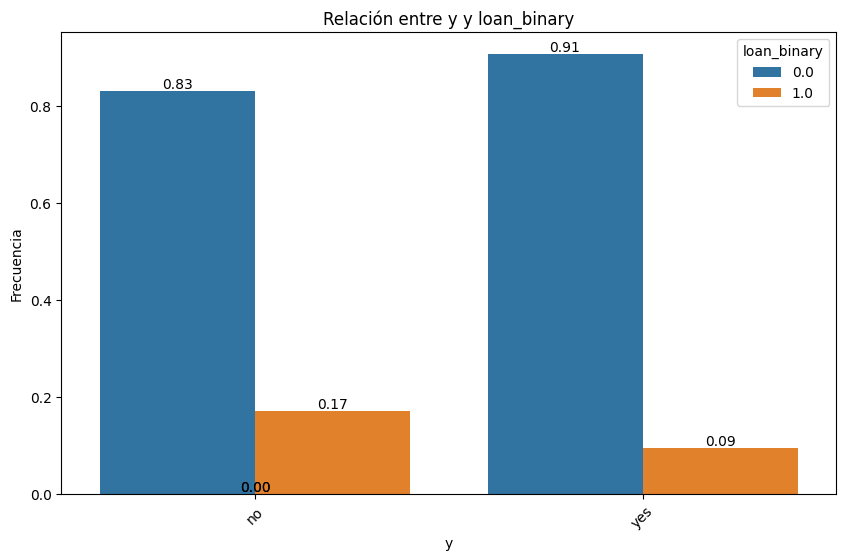

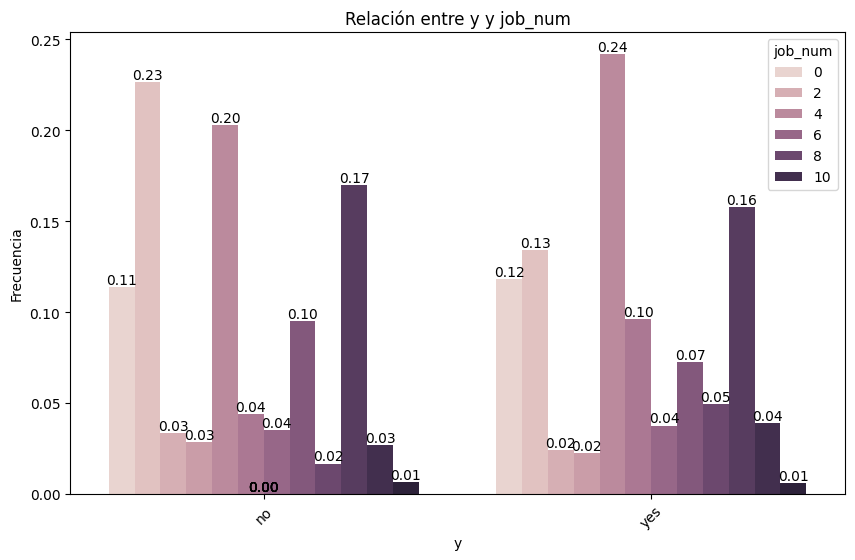

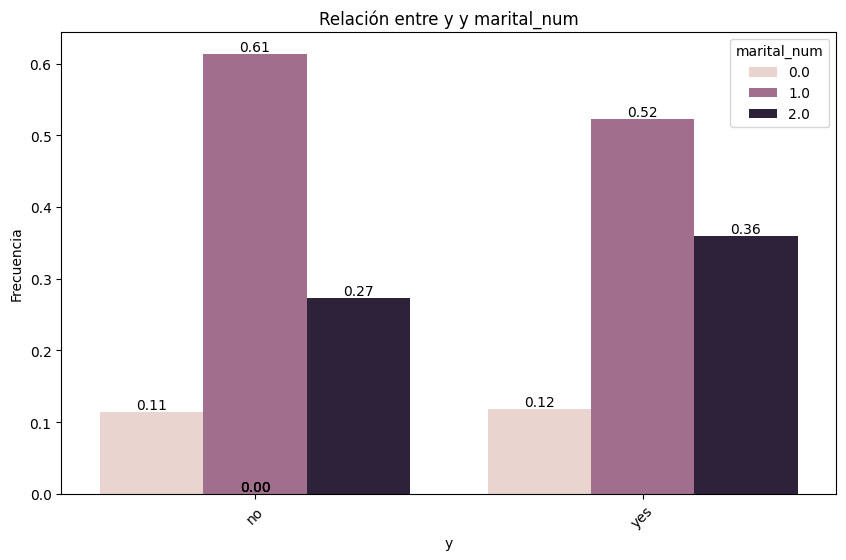

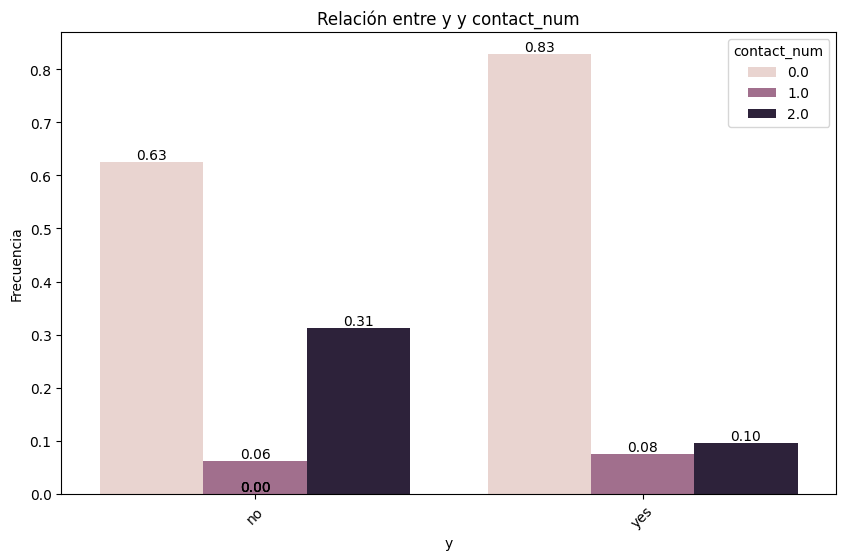

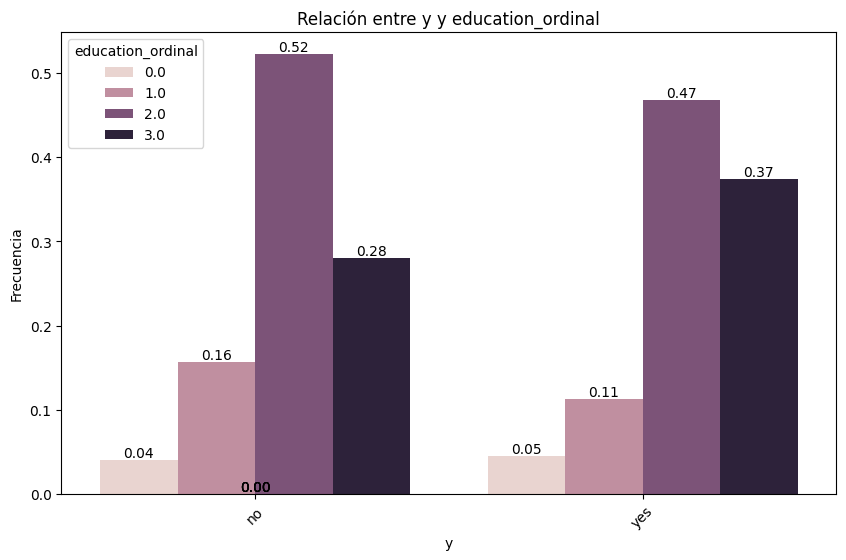

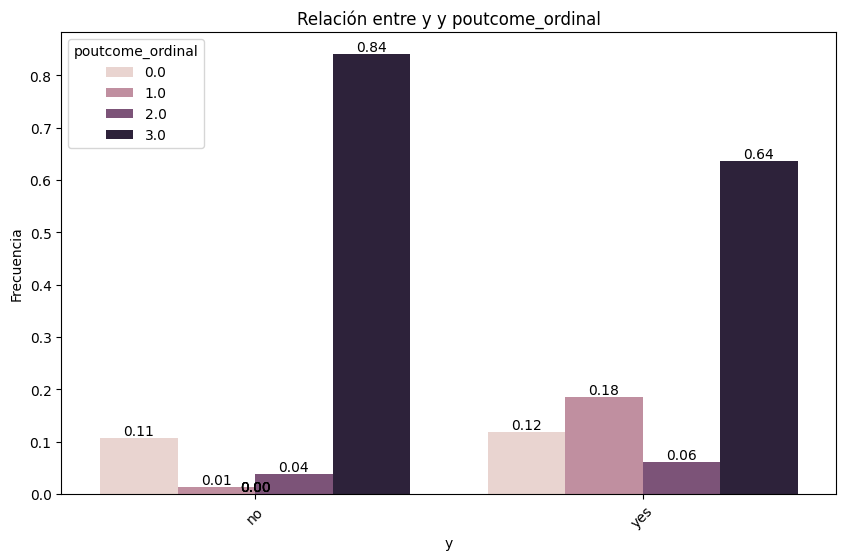

In [621]:
# Pintamos el bivariante del target contra cada feature 
for catego in features_catego:
    plot_categorical_relationship_fin(df_eda, "y", catego, show_values=True, relative_freq= True,)

De las gráficas de barras observamos que hay claros subgrupos donde deberíamos centrarnos:
- 'age': en los rangos de edad entre 20-40 y 40-60.
- 'loan' y 'housing': los clientes que ya tienen una hipoteca o préstamo personal son potencialmente compradores del depósito a plazo
- 'marital' y 'education' muestran una distribución parecida entre el SÍ y el NO, pero puede merecer la pena centrarnos en los casados y en los niveles de secondary y tertiary para vender más depósitos.
- 'default' no aporta mucho, nos desprendemos de esta variable.

In [622]:
# PARA LAS NUMÉRICAS

# calculamos el p-value para las numericas, recordemos cuáles son:

lista_numericas

['balance', 'day', 'duration', 'campaign']

In [623]:
features_num = []
for numerica in lista_numericas:
        
    grupo_a = df_eda.loc[df_eda.y == "yes"][numerica]
    grupo_b = df_eda.loc[df_eda.y == "no"][numerica]

# empleamos el test U de mann whitney puesto que queremos testear una binaria (target) contra variables numéricas 
    u_stat, p_value = mannwhitneyu(grupo_a, grupo_b)

    if p_value <= 0.05:   # igual que hicimos con las categóricas, todas aquellas cuyo pvaleu sea igual o inferior a 0.05, entran en la lista de selección de features
        features_num.append(numerica)   
        print(f"P-value de {numerica}: contra target", p_value)

# Todas superan el umbral de confianza estadística del 95%.
# La que más discrimina más es previous, seguida de balance. Vemos que de nuevo hay una variable con pvalue resultado 0 --> duration, veremos qué hacemos con ella.
print("\n")
print("Selección de features numéricas:")
features_num

P-value de balance: contra target 1.5816927437308728e-77
P-value de day: contra target 3.981453394666329e-07
P-value de duration: contra target 0.0
P-value de campaign: contra target 2.201202509523113e-53


Selección de features numéricas:


['balance', 'day', 'duration', 'campaign']

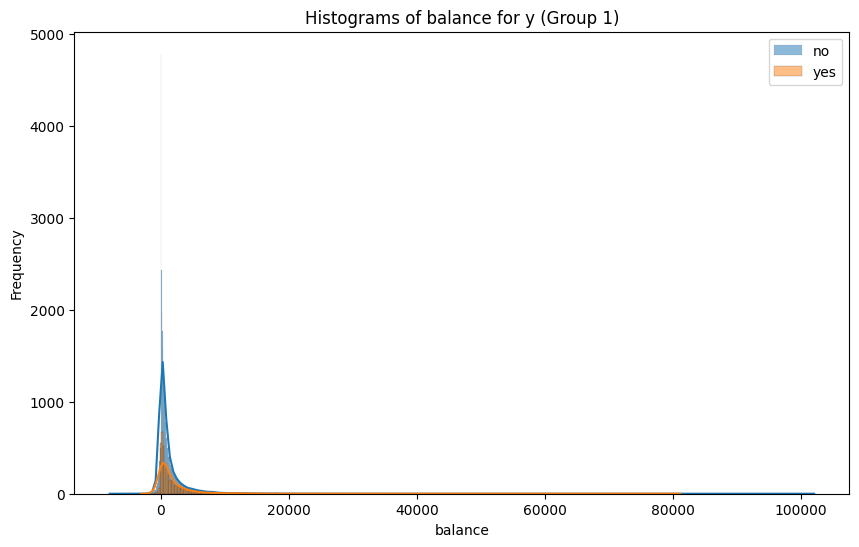

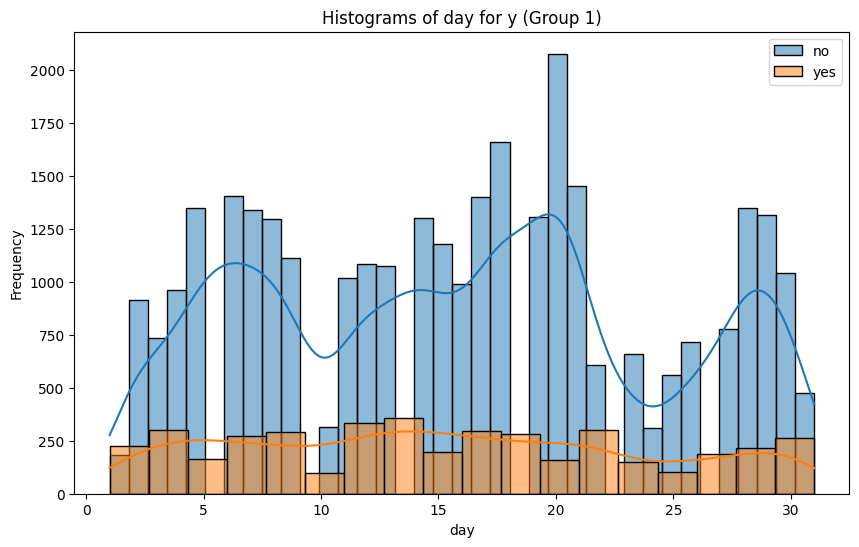

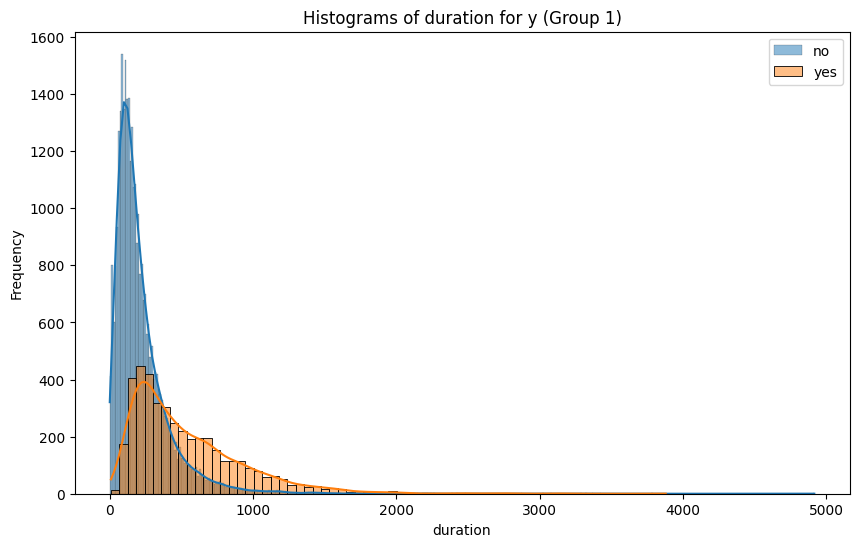

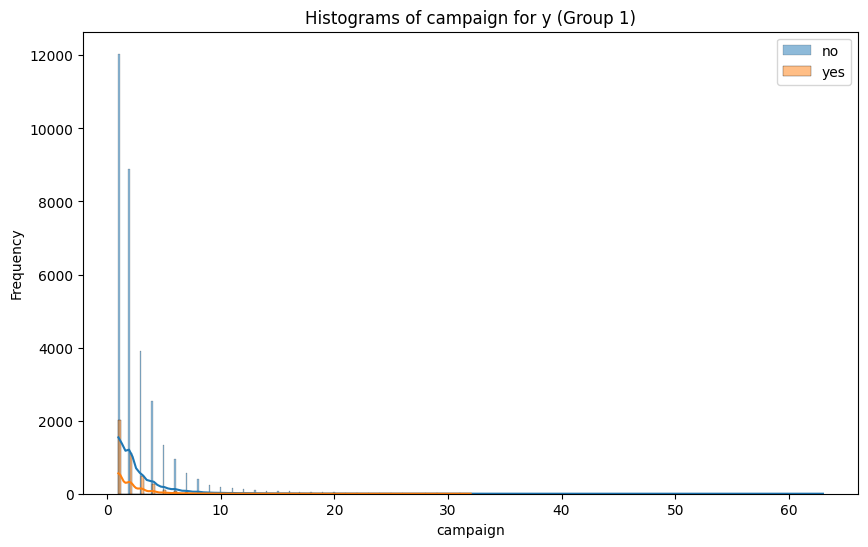

In [624]:
# pintamos los histogramas + kde de l target para cada variable numérica

for num in features_num:
    plot_grouped_histograms(df_eda, "y",num, group_size=2)

La mayoría son difíciles de interpretar a causa de la descompensación de los datos. Aun así, es evidente la supremacía del NO (cliente NO comprará un depósito a plazo). La gráfica más interesante es la de 'duration', donde se observa claramente como el SÍ aumenta en valores hasta superar al NO cuanto más se incrementa el tiempo de duración. Negocio deberá buscar la forma de hacer que los clientes no corten la llamada y se interesen por lo que les está contando el empleado de banca/ márketing.

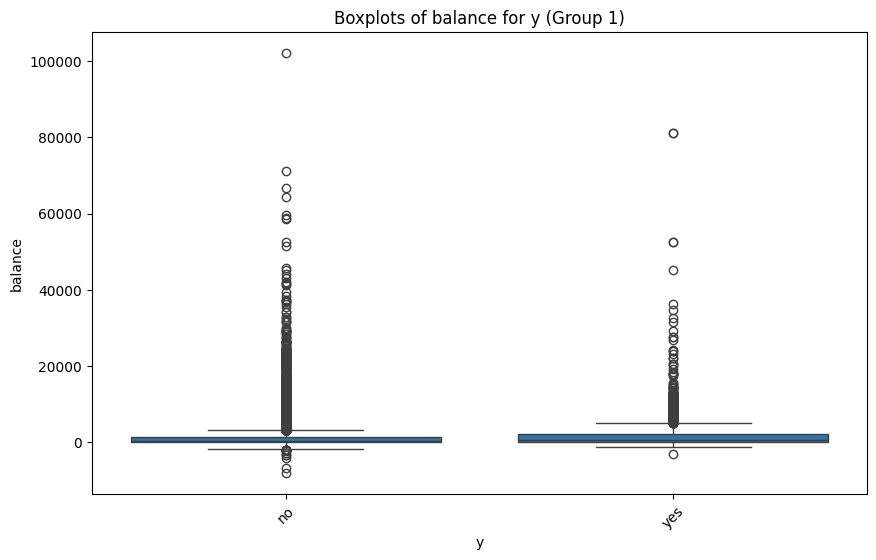

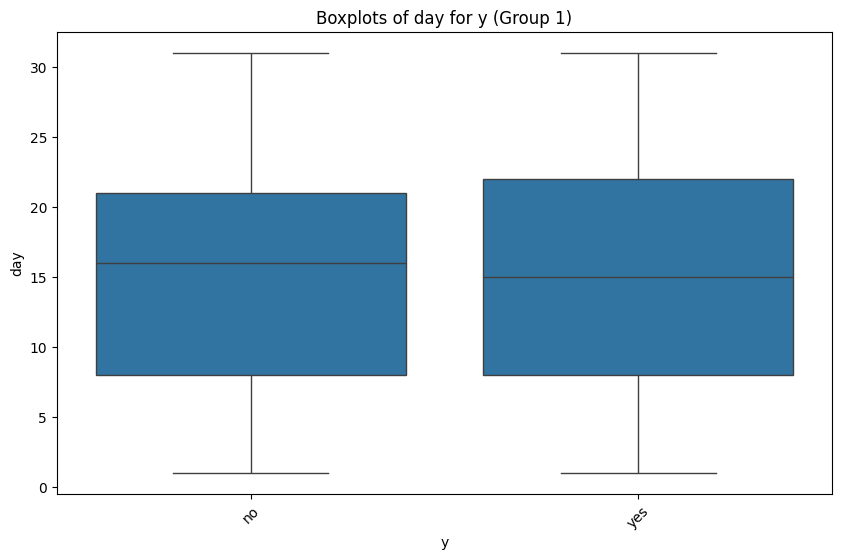

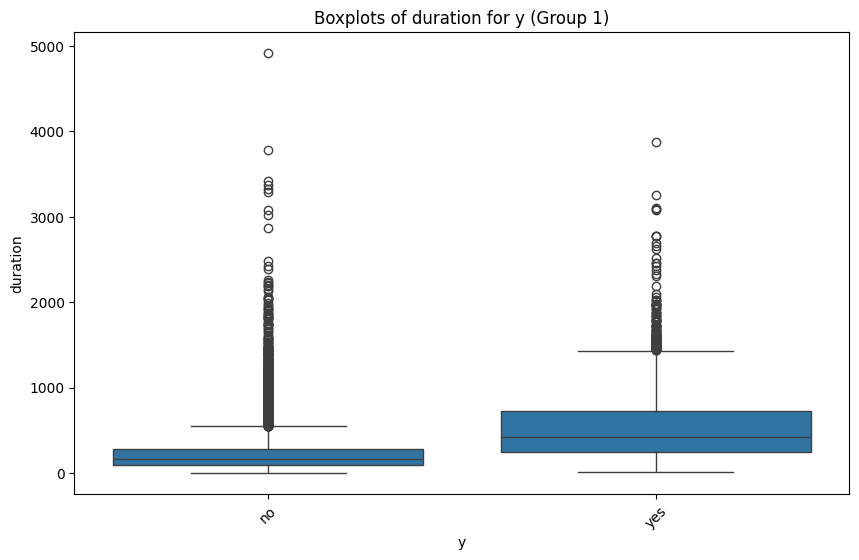

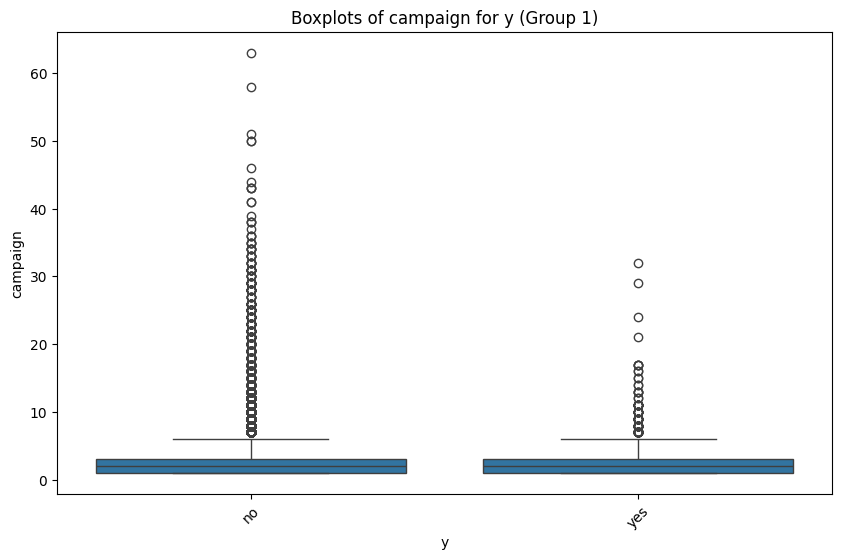

In [625]:
# ahora pintamos los boxplots

for num in features_num:
    plot_grouped_boxplots(df_eda,"y", num)

De las gráficas anteriores, podemos observar cómo las curvas de las variables 'day', 'balance' y 'campaing' son paralelas en ambos valores del target (no hay interacción entre ellas). El balance en cada una es muy parecido aunque el peso de los datos caiga en el NO. Vamos a tenerlo en cuenta para entrenar un modelo sin estas variables. 

In [626]:
# nos desprendemos de 'day', 'balance', 'campaing' y 'default' tras el bivariante, tanto en train como en test

X_train.drop(columns=["default_binary","day","balance","campaign"], inplace=True)

X_test.drop(columns=["default_binary","day","balance","campaign"], inplace=True)

In [627]:
# por último veamos la distribución de las numéricas para valorar si necesitan alguna transformación previa al entrenamiento

features_num # la única que nos queda de aquí es 'duration'

['balance', 'day', 'duration', 'campaign']

<Axes: >

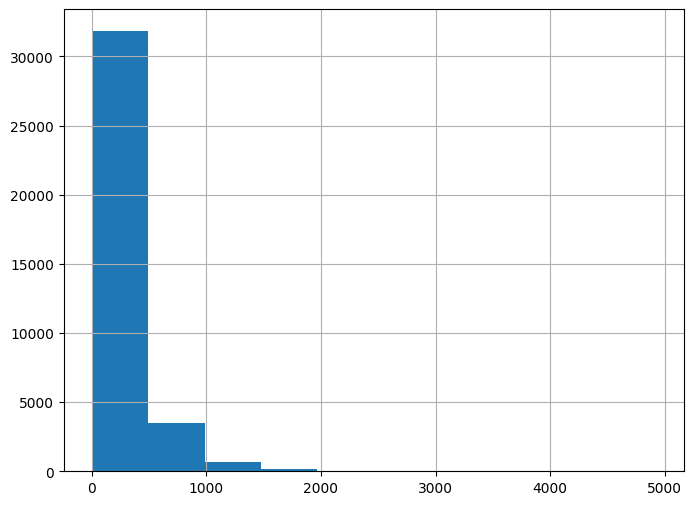

In [628]:
df_eda['duration'].hist(figsize = (8,6))

In [629]:
 # le aplicamos el logaritmo para evitar esa larga cola 

X_train.duration = (X_train['duration']+1).apply(np.log)
X_test.duration = (X_test['duration']+1).apply(np.log)

<Axes: >

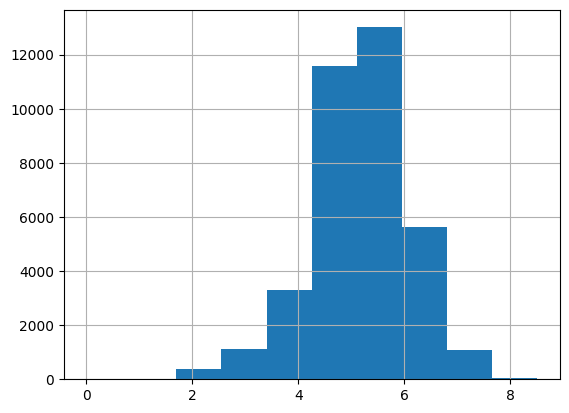

In [630]:
X_train['duration'].hist() # ya la tenemos un poco más compensada

### Entrenamiento del modelo y evaluación contra test

In [631]:
tree_clf = DecisionTreeClassifier()

# primer entrenamiento sin tocar hiperparámetros

tree_clf.fit(X_train,y_train)     
tree_pred = tree_clf.predict(X_test)

In [632]:
print("Para Árbol de decisión:")
print(classification_report(y_test, tree_pred))

Para Árbol de decisión:
              precision    recall  f1-score   support

          no       0.93      0.92      0.93      7952
         yes       0.46      0.48      0.47      1091

    accuracy                           0.87      9043
   macro avg       0.69      0.70      0.70      9043
weighted avg       0.87      0.87      0.87      9043



### Optimización de hiperparámetros

In [650]:
# RANDOMIZED SEARCH
#  tuneamos un poco los hiperparámetros y probamos combinaciones con un randomized search para entrenarlo por segunda vez 
tree_param_grid = {
    'max_depth': [None] + list(range(1, 15)),
    'min_samples_split': [2,4,8,10,12],
    'min_samples_leaf': [2,4,8,10,12]
}

tree_clf = DecisionTreeClassifier()

random_search = RandomizedSearchCV(tree_clf, # El modelo que quiero entrenar
                                   tree_param_grid, # El grid de parámetros
                                   random_state=42, # Semilla
                                   n_iter=125, # Nº de iteraciones del random search
                                   cv=4, # Folds del cross validation
                                   scoring="balanced_accuracy", # Métrica que quiero optimizar
                                   n_jobs = -1 # Paralelizar, va a arrancar varios programas para que el ordenador pruebe los modelos en paralelo, no uno x uno
                                  )

random_search.fit(X_train, y_train)   # con esta sintaxis, le pedimos que lo randomice

RandomizedSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_iter=125,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13,
                                                      14],
                                        'min_samples_leaf': [2, 4, 8, 10, 12],
                                        'min_samples_split': [2, 4, 8, 10, 12]},
                   random_state=42, scoring='balanced_accuracy')

In [651]:
# Mejores parámetros del modelo
random_search.best_params_

{'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 11}

In [652]:
# Mejor score 
random_search.best_score_

np.float64(0.6959114168299038)

In [653]:
tree_pred = random_search.best_estimator_.predict(X_test)
random_search.best_estimator_.score(X_test, y_test) 

0.8895278115669578

In [654]:
print("Para Árbol de decisión randomized:")
print(classification_report(y_test, tree_pred))

# observamos que las métricas han mejorado con respecto al report anterior excepto en 'yes' de recall (la media es similar, un tanto mejor)
# precision ha mejorado bastante y accuracy ligeramente

Para Árbol de decisión randomized:
              precision    recall  f1-score   support

          no       0.93      0.95      0.94      7952
         yes       0.55      0.46      0.50      1091

    accuracy                           0.89      9043
   macro avg       0.74      0.70      0.72      9043
weighted avg       0.88      0.89      0.89      9043



In [655]:
# GRID SEARCH
# los resultados del randomized nos decian que el mejor valor de max_depth era 11, el de min_samples_split era 8 y el de leaf 2, vamos a ajustar el dict de parametros cerca de
# estos valores para el gridsearch:

tree_param_grid = {
    'max_depth': [None] + list(range(7, 14)),
    'min_samples_split': [7,8,9],
    'min_samples_leaf': [1,2,3,4]
}

tree_grid_search = GridSearchCV(tree_clf, tree_param_grid, cv=5, scoring='balanced_accuracy')
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 7, 8, 9, 10, 11, 12, 13],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [7, 8, 9]},
             scoring='balanced_accuracy')

In [656]:
tree_grid_search.best_params_

{'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 7}

In [657]:
# Mejor score 
tree_grid_search.best_score_

np.float64(0.7046690421484059)

In [658]:
print("Para Árbol de decisión gridsearch:")
y_pred = tree_grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

# Hemos mejorado ligeramente las métricas con respecto a randomized. 
# Además, hemos mantenido el recall 'yes', que es la más interesante de todas, pues queremos que nuestro modelo prediga con la mayor sensibilidad posible quién es un potencial comprador

Para Árbol de decisión gridsearch:
              precision    recall  f1-score   support

          no       0.93      0.95      0.94      7952
         yes       0.56      0.46      0.51      1091

    accuracy                           0.89      9043
   macro avg       0.74      0.71      0.72      9043
weighted avg       0.88      0.89      0.89      9043



In [649]:
# LOGISTIC REGRESSION 

# probemos ahora con la regresión logística sin tocar los hiperparámetros
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)

print("Para Regresión Logística")
print(classification_report(y_test, lr_pred))

# en general el resultado de las métricas empeora, sobre todo el de recall 'yes', bajando un 25% de lo que conseguíamos con los árboles de decisión

Para Regresión Logística
              precision    recall  f1-score   support

          no       0.90      0.97      0.94      7952
         yes       0.56      0.25      0.35      1091

    accuracy                           0.89      9043
   macro avg       0.73      0.61      0.64      9043
weighted avg       0.86      0.89      0.87      9043



### Conclusión

Tras la comparación de los diversos modelos y/o uso de hiperparámetros, nos quedamos con el obtenido el de árboles de decisiones obtenidos tras el aplicar Grid Search, puesto que en general mejora todas las métricas del report de clasificación, además de obtener un 46% de acierto en recall para aquellos clientes que SÍ comprarán el depósito. Al ser el target una variable tan descompensada (recordemos que teníamos un 88% de NO frente a un 12% de SÍ), el recall es la métrica que más nos interesa, ya que no queremos que se nos escape un potencial cliente.